In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import psutil
from pathlib import Path

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:
# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset (use SelfCollectedTest or dataset/test as needed)
test_folder = "SelfCollectedTest"  # Change to "dataset/test" for online test set
test_ds = datasets.ImageFolder(test_folder, transform=val_transforms)
test_ld = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# Define CustomCNN class (same as in CustomCNN_BaseLine.ipynb)
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction layers
        self.features = torch.nn.Sequential(
            # First Conv Block
            torch.nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second Conv Block
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third Conv Block
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth Conv Block
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fifth Conv Block
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [3]:
# List of models to evaluate
model_configs = {
    "MobileNetV3-Small": {
        "model": models.mobilenet_v3_small(weights="IMAGENET1K_V1"),
        "path": "best_mnv3_small.pth",
        "num_params": 1.5e6
    },
    "ResNet50": {
        "model": models.resnet50(weights="IMAGENET1K_V1"),
        "path": "best_resnet50.pth",
        "num_params": 23.5e6
    },
    "EfficientNet-B0": {
        "model": models.efficientnet_b0(weights="IMAGENET1K_V1"),
        "path": "best_efficientnet_b0.pth",
        "num_params": 5.3e6
    },
    "MobileNetV2": {
        "model": models.mobilenet_v2(weights="IMAGENET1K_V1"),
        "path": "best_mobilenet_v2.pth",
        "num_params": 3.5e6
    },
    "VGG16": {
        "model": models.vgg16(weights="IMAGENET1K_V1"),
        "path": "best_vgg16.pth",
        "num_params": 138e6
    },
    "CustomCNN": {
        "model": SimpleCNN(num_classes=2),
        "path": "best_custom_cnn.pth",
        "num_params": 5.0e6  # Actual parameter count from SimpleCNN
    }
}

In [4]:
# Modify models for 2 classes (diabetes, nondiabetes)
for model_name, config in model_configs.items():
    model = config["model"]
    if model_name.startswith("ResNet"):
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("MobileNetV3"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("MobileNetV2"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("EfficientNet"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("VGG"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name == "CustomCNN":
        # Already configured for 2 classes in the placeholder
        pass
    config["model"] = model.to(device)

In [5]:
# Function to calculate model size
def get_model_size(model_path):
    if os.path.exists(model_path):
        size_bytes = os.path.getsize(model_path)
        return size_bytes / (1024 * 1024)  # Convert to MB
    return None

In [6]:
# Function to calculate inference time and memory usage
def measure_inference_metrics(model, data_loader, device):
    model.eval()
    inference_times = []
    memory_usages = []
    
    process = psutil.Process()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            
            # Measure inference time
            start_time = time.time()
            _ = model(x)
            end_time = time.time()
            inference_times.append((end_time - start_time) * 1000)  # Convert to ms
            
            # Measure memory usage
            mem_info = process.memory_info()
            memory_usages.append(mem_info.rss / (1024 * 1024))  # Convert to MB
    
    avg_inference_time = np.mean(inference_times)
    avg_memory_usage = np.mean(memory_usages)
    return avg_inference_time, avg_memory_usage

In [7]:
# Function to estimate energy consumption (simplified model)
def estimate_energy_consumption(inference_time_ms, num_params):
    # Simplified energy model: energy (J) = inference time (s) * power (W)
    # Assume 3W for CPU inference per image (adjust based on your device)
    power_watts = 3.0
    inference_time_s = inference_time_ms / 1000
    return inference_time_s * power_watts

In [8]:
# Evaluate deployment metrics for each model
results = []
for model_name, config in model_configs.items():
    model = config["model"]
    model_path = config["path"]
    num_params = config["num_params"]
    
    # Load pretrained weights
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    else:
        print(f"Warning: {model_path} not found, skipping {model_name}")
        continue
    
    # Calculate model size
    model_size = get_model_size(model_path)
    
    # Measure inference time and memory usage
    inference_time, memory_usage = measure_inference_metrics(model, test_ld, device)
    
    # Estimate energy consumption
    energy = estimate_energy_consumption(inference_time, num_params)
    
    results.append({
        "Model": model_name,
        "Model Size (MB)": model_size,
        "Inference Time (ms)": inference_time,
        "Memory Usage (MB)": memory_usage,
        "Energy (J/image)": energy,
        "Parameters (M)": num_params / 1e6
    })
    
    print(f"Processed {model_name}: {inference_time:.2f}ms, {model_size:.2f}MB")

Processed MobileNetV3-Small: 11.14ms, 5.93MB
Processed ResNet50: 13.05ms, 90.00MB
Processed EfficientNet-B0: 16.26ms, 15.59MB
Processed MobileNetV2: 10.73ms, 8.73MB
Processed VGG16: 2.98ms, 512.21MB
Processed CustomCNN: 2.14ms, 6.65MB


In [9]:
# Print results in a table format
print("\nDeployment Metrics:")
print("-" * 110)
print(f"{'Model':<20} {'Model Size (MB)':<15} {'Inference Time (ms)':<20} {'Memory Usage (MB)':<20} {'Energy (J/image)':<15} {'Parameters (M)':<15}")
print("-" * 110)
for result in results:
    print(f"{result['Model']:<20} {result['Model Size (MB)']:<15.2f} {result['Inference Time (ms)']:<20.2f} {result['Memory Usage (MB)']:<20.2f} {result['Energy (J/image)']:<15.6f} {result['Parameters (M)']:<15.1f}")
print("-" * 110)

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("deployment_metrics.csv", index=False)
print("\nResults saved to deployment_metrics.csv")

# Display ranking by efficiency metrics
print("\n=== MODEL RANKING BY EFFICIENCY ===")
print("\n1. By Inference Speed (faster = better):")
df_speed = df.sort_values('Inference Time (ms)')
for i, row in df_speed.iterrows():
    print(f"   {row.name+1}. {row['Model']}: {row['Inference Time (ms)']:.2f} ms")

print("\n2. By Model Size (smaller = better):")
df_size = df.sort_values('Model Size (MB)')
for i, row in df_size.iterrows():
    print(f"   {row.name+1}. {row['Model']}: {row['Model Size (MB)']:.2f} MB")

print("\n3. By Energy Efficiency (lower = better):")
df_energy = df.sort_values('Energy (J/image)')
for i, row in df_energy.iterrows():
    print(f"   {row.name+1}. {row['Model']}: {row['Energy (J/image)']:.6f} J")


Deployment Metrics:
--------------------------------------------------------------------------------------------------------------
Model                Model Size (MB) Inference Time (ms)  Memory Usage (MB)    Energy (J/image) Parameters (M) 
--------------------------------------------------------------------------------------------------------------
MobileNetV3-Small    5.93            11.14                1492.06              0.033423        1.5            
ResNet50             90.00           13.05                904.77               0.039154        23.5           
EfficientNet-B0      15.59           16.26                925.74               0.048772        5.3            
MobileNetV2          8.73            10.73                927.30               0.032179        3.5            
VGG16                512.21          2.98                 997.78               0.008941        138.0          
CustomCNN            6.65            2.14                 934.50               0.006426   

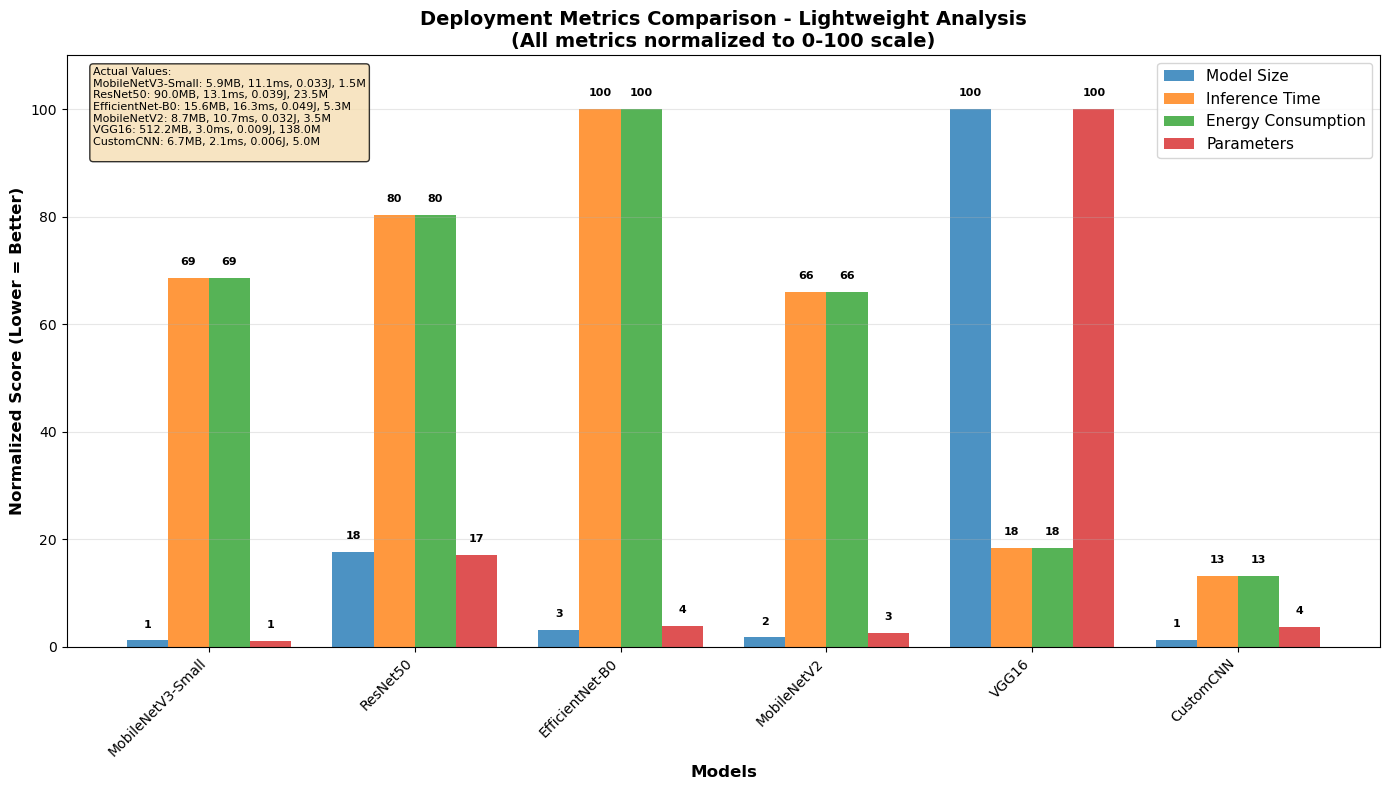

Deployment metrics comparison saved as: deployment_metrics_comparison.png

📱 LIGHTWEIGHT MODEL RANKING
🥇 CustomCNN: Score 7.8
   Size: 6.7MB | Time: 2.1ms | Energy: 0.006J

🥈 MobileNetV2: Score 34.0
   Size: 8.7MB | Time: 10.7ms | Energy: 0.032J

🥉 MobileNetV3-Small: Score 34.8
   Size: 5.9MB | Time: 11.1ms | Energy: 0.033J

🏅 ResNet50: Score 48.8
   Size: 90.0MB | Time: 13.1ms | Energy: 0.039J

📱 EfficientNet-B0: Score 51.7
   Size: 15.6MB | Time: 16.3ms | Energy: 0.049J

🔧 VGG16: Score 59.2
   Size: 512.2MB | Time: 3.0ms | Energy: 0.009J



<Figure size 640x480 with 0 Axes>

In [10]:
# Deployment Metrics Visualization - Single Comprehensive Graph
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
df_viz = pd.DataFrame(results)

# Create a single figure with grouped bar chart
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

models = df_viz['Model'].values
x = np.arange(len(models))
width = 0.2

# Normalize metrics for better comparison (scale to 0-100 for visualization)
size_norm = (df_viz['Model Size (MB)'] / df_viz['Model Size (MB)'].max()) * 100
time_norm = (df_viz['Inference Time (ms)'] / df_viz['Inference Time (ms)'].max()) * 100
energy_norm = (df_viz['Energy (J/image)'] / df_viz['Energy (J/image)'].max()) * 100
params_norm = (df_viz['Parameters (M)'] / df_viz['Parameters (M)'].max()) * 100

# Create grouped bars
bars1 = ax.bar(x - 1.5*width, size_norm, width, label='Model Size', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, time_norm, width, label='Inference Time', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, energy_norm, width, label='Energy Consumption', color='#2ca02c', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, params_norm, width, label='Parameters', color='#d62728', alpha=0.8)

# Customize the plot
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Normalized Score (Lower = Better)', fontweight='bold', fontsize=12)
ax.set_title('Deployment Metrics Comparison - Lightweight Analysis\n(All metrics normalized to 0-100 scale)', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 110)

# Add value labels on bars
for i, (s, t, e, p) in enumerate(zip(size_norm, time_norm, energy_norm, params_norm)):
    ax.text(i - 1.5*width, s + 2, f'{s:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i - 0.5*width, t + 2, f'{t:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 0.5*width, e + 2, f'{e:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(i + 1.5*width, p + 2, f'{p:.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Add actual values as text box
textstr = 'Actual Values:\n'
for i, row in df_viz.iterrows():
    textstr += f"{row['Model']}: {row['Model Size (MB)']:.1f}MB, {row['Inference Time (ms)']:.1f}ms, {row['Energy (J/image)']:.3f}J, {row['Parameters (M)']:.1f}M\n"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('deployment_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("Deployment metrics comparison saved as: deployment_metrics_comparison.png")

# Print lightweight ranking summary
print("\n" + "="*50)
print("📱 LIGHTWEIGHT MODEL RANKING")
print("="*50)

# Calculate lightweight score (average of normalized metrics - lower is better)
df_viz['Lightweight Score'] = (size_norm + time_norm + energy_norm + params_norm) / 4
df_sorted = df_viz.sort_values('Lightweight Score')

for i, (_, row) in enumerate(df_sorted.iterrows()):
    rank_emoji = ["🥇", "🥈", "🥉", "🏅", "📱", "🔧"][i] if i < 6 else f"#{i+1}"
    print(f"{rank_emoji} {row['Model']}: Score {row['Lightweight Score']:.1f}")
    print(f"   Size: {row['Model Size (MB)']:.1f}MB | Time: {row['Inference Time (ms)']:.1f}ms | Energy: {row['Energy (J/image)']:.3f}J")
    print()